In [205]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [206]:
pp_train = pd.read_csv("pp_train.csv")
pp_class = pp_train.copy()


### Preprocessing delle variabili

Mapping variabile target

In [207]:

y = np.array(pp_class['titleType'])  # Il target originale

# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)

print(y_map)  # Per vedere la mappatura delle categorie

{'tvEpisode': 0, 'videoGame': 1, 'movie': 2, 'tvSeries': 3, 'video': 4, 'tvMiniSeries': 5, 'short': 6, 'tvMovie': 7, 'tvSpecial': 8, 'tvShort': 9}


##### info variabili

In [208]:
#studio variabili (non ho messo le 28 is_genere)
pp_class[['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes', 'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins', 'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
          #'countryOfOrigin', 
       'fill_runtimeMinutes', 'titleType_encoded']].head(3)

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isAdult,numRegions,userReviewsTotal,fill_runtimeMinutes,titleType_encoded
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,1995.0,NaN,0.0,779,1,0,21,1,tvEpisode,0,False,0,1,0,40.0,0
1,Looping,6,1982,1982.0,NaN,0.0,11,1,0,1,0,videoGame,0,False,0,1,0,28.0,1
2,Idealnaya para,6,1992,1992.0,NaN,0.0,38,1,0,24,0,movie,0,False,0,1,1,90.0,2


In [209]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'titleType_encoded'],
      dtype='object')

gestione country of origin  -> già sul train -> codice su modifiche_test

Conversione CanHaveEpisodes in binaria 0/1

In [210]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [211]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)

END YEAR-> tolto finchè non capiamo come gestirlo

In [212]:
# Riempi i valori mancanti di 'endYear' con quelli di 'startYear' 
# -> DA VEDERE PERCHE' FATTO COME IN TEORIA HA FATTO BRUNO LASCIA COMUNQUE NAN
#pp_class['endYear'].fillna(pp_class['startYear'], inplace=True)

#OPPURE RIMUOVI
pp_class= pp_class.drop(["endYear"], axis=1)

BINARIZZAZIONE -> da capire

In [213]:
#binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)
    # Alternativa: Se vuoi mantenere i valori numerici, puoi discretizzare in fasce (es. 0, 1-5, >5).
pp_class['awardWins_bin'] = (pp_class['awardWins'] > 0).astype(int)
pp_class['totalVideos_bin'] = (pp_class['totalVideos'] > 0).astype(int)
pp_class['awardNominations_bin'] = (pp_class['awardNominationsExcludeWins'] > 0).astype(int)

### ? Encoding di titletype per multiclass classification task

In [214]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy

### creazione array di valori -> da cui scegliere feature da usare

In [215]:
#X_train = pp_class.values
X_train = pp_class[['rating', 'startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal',
       'awardNominationsExcludeWins', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', 
       #'endYear',
       #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
       'fill_runtimeMinutes', 
       'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
       'awardWins_bin', 'totalVideos_bin', 'awardNominations_bin']].values


### Splitting in validation 
##### -> penso su y_train (array valori multilabeled)

In [216]:


X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32
)
""" 

X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y, test_size=0.2, random_state=32
)
"""


# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

' \n\nX_train2, X_val, y_train2, y_val = train_test_split(\n     X_train, y, test_size=0.2, random_state=32\n)\n'

### Normalization

capire se log su tutte o no -> penso di si

In [217]:
X_train2_log = np.log1p(X_train)
X_val_log= np.log1p(X_val)

In [218]:

standardsc = StandardScaler()

# # Fitta e trasforma il training set in un solo passaggio
X_train2_standardsc = standardsc.fit_transform(X_train2_log)
X_val_standardsc = standardsc.fit_transform(X_val_log)

# # Trasforma il test set (senza rifittare!)
# # X_test_standardsc = standardsc.transform(X_test)

In [219]:
# minmax = MinMaxScaler()

# # Fitta e trasforma il training set in un solo passaggio
# X_train2_minmax = minmax.fit_transform(X_train2_log)
# X_val_minmax = minmax.fit_transform(X_val_log)


# # Trasforma il test set (senza rifittare!)
# #X_test_minmax = minmax.transform(X_test)



In [220]:
X_train2_tr = X_train2_standardsc
X_val_tr = X_val_standardsc

## NAIVE BAYES

In [221]:
clf = GaussianNB()

In [222]:
clf.fit(X_train2, y_train2)

GaussianNB()

In [223]:
y_pred = clf.predict(X_val)
y_pred

array([3, 8, 8, ..., 0, 0, 6], dtype=int64)

In [224]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68       936
           1       0.43      0.06      0.11        50
           2       0.91      0.17      0.29      1121
           3       0.60      0.12      0.19       268
           4       0.34      0.28      0.31       163
           5       0.12      0.22      0.16        37
           6       0.61      0.74      0.67       501
           7       0.09      0.19      0.12       173
           8       0.01      0.21      0.02        28
           9       0.04      0.40      0.07        10

    accuracy                           0.44      3287
   macro avg       0.37      0.32      0.26      3287
weighted avg       0.65      0.44      0.44      3287



In [225]:
clf.predict_proba(X_val)
#prob che un record appartenga alle classi

array([[1.40403095e-283, 6.40158638e-259, 1.78042505e-006, ...,
        4.44867109e-076, 4.66737110e-141, 0.00000000e+000],
       [1.56376769e-007, 0.00000000e+000, 1.63516438e-007, ...,
        6.15769255e-002, 7.44253452e-001, 3.03813548e-213],
       [2.01129405e-003, 0.00000000e+000, 8.92582046e-006, ...,
        2.22521577e-001, 6.45176455e-001, 8.99882168e-082],
       ...,
       [9.35298379e-001, 4.20847277e-005, 5.25364445e-009, ...,
        1.64199609e-003, 6.18487020e-002, 3.77498377e-012],
       [6.71526274e-001, 1.05151410e-005, 1.38184620e-009, ...,
        1.72429889e-003, 1.02602537e-002, 4.28779872e-005],
       [4.51148183e-003, 9.50555585e-057, 1.77554027e-011, ...,
        8.57474199e-005, 9.57499927e-004, 8.33377742e-002]])

roc test

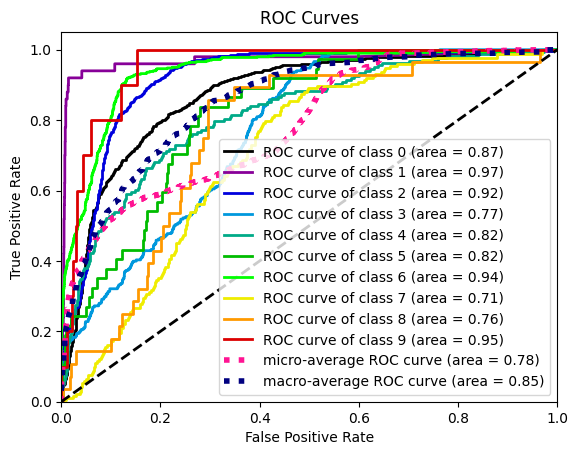

0.8526391473589288


In [226]:
plot_roc(y_val, clf.predict_proba(X_val))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val), multi_class="ovr", average="macro"))